## Useful code for processing test data

### Imports

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

### Time test for files

In [40]:
MAX_MEASURES = 12

def show_time_plot_per_test(TEST_FILES, DUMMY_FILE, SOURCE_FILE_SIZE, title, output_file):
    with open(DUMMY_FILE) as file:
        dummy_values = np.array(file.read().split()).astype(float)

    df_time_duration = pd.DataFrame()

    for filename, plot_name in TEST_FILES:
        values = np.array([])
        with open(filename) as file:
            unclean_values = np.array(file.read().split()).astype(float)
            values = unclean_values - dummy_values

            mask = np.ones(len(values), dtype=bool)
            mask[np.argmin(values)] = mask[np.argmax(values)] = False
            values = values[mask]

            # Take only the first 12 measures
            if len(values) > MAX_MEASURES:
                values = values[:MAX_MEASURES]

            # Divide all values by file size
            values = values / SOURCE_FILE_SIZE

        df_time_duration[plot_name] = pd.DataFrame(values)

    axes = df_time_duration.boxplot(figsize=(8, 5), grid=False)
    axes.grid(axis="y")
    axes.set_ylabel('Capacity [sec/B]')
    plt.tight_layout()

    plt.title(title)
    plt.savefig(output_file)
    plt.show()

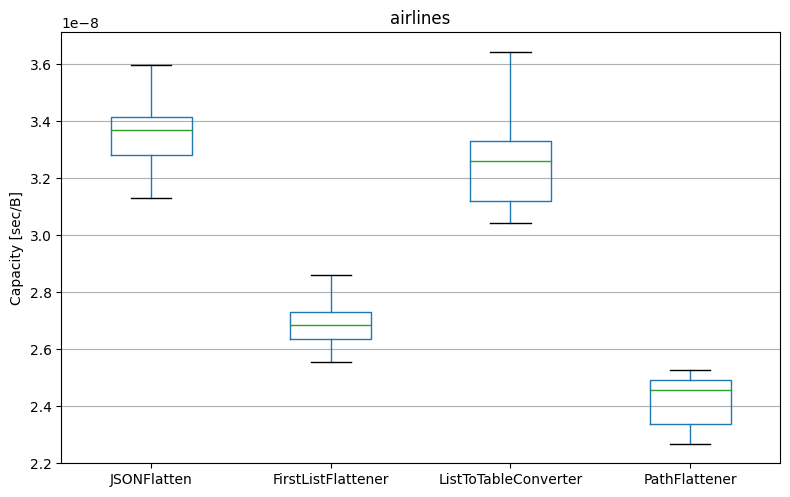

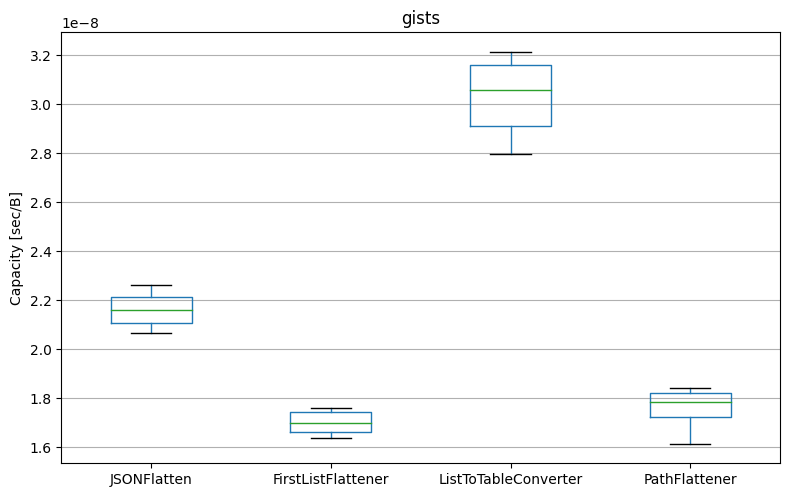

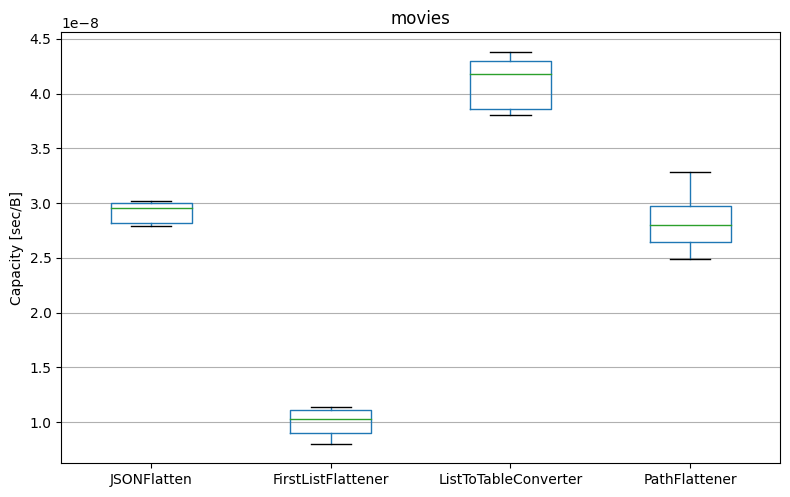

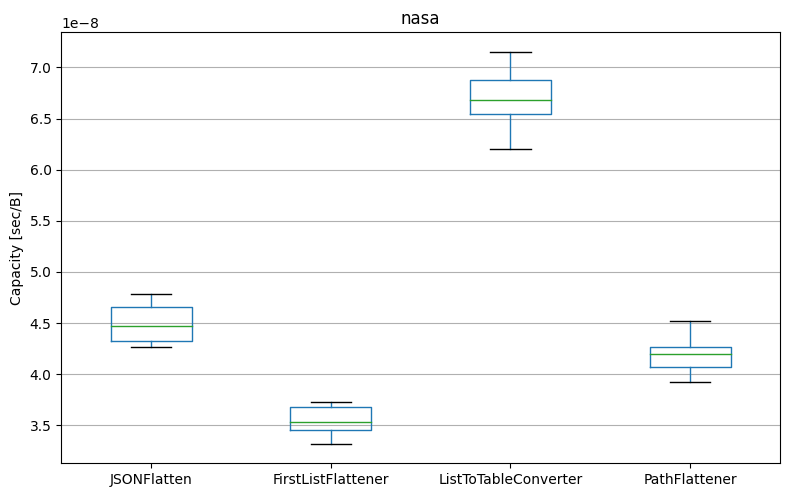

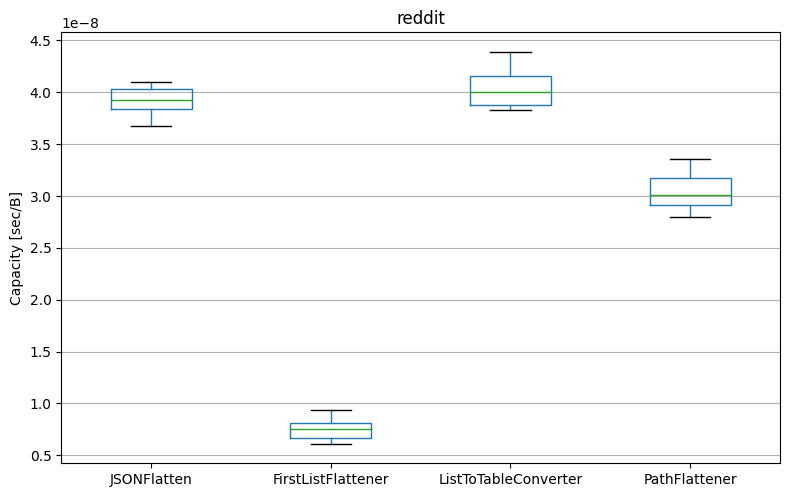

In [41]:
# TEST with files generated from ballooner PER TEST
test_names = [
    "airlines",
    "gists",
    "movies",
    "nasa",
    "reddit",
]

for test_name in test_names:
    SOURCE_FILE_SIZE = os.stat(f"../../data/testFiles/{test_name}.txt").st_size
    TEST_FILES = [
        (f"time/{test_name}-JSONFlatten.txt", "JSONFlatten"),
        (f"time/{test_name}-JSONFirstListFlattener.txt", "FirstListFlattener"),
        (f"time/{test_name}-JSONListToTableConverter.txt", "ListToTableConverter"),
        (f"time/{test_name}-JSONPathFlattener.txt", "PathFlattener"),
    ]
    DUMMY_FILE = f"time/{test_name}-JSONDummy.txt"
    output_file = f"time/charts/{test_name}.png"

    show_time_plot_per_test(TEST_FILES, DUMMY_FILE, SOURCE_FILE_SIZE, test_name, output_file)

# --------------------------

In [42]:
MAX_MEASURES = 12

def get_test_props(test_name: str):
    SOURCE_FILE_SIZE = os.stat(f"../../data/testFiles/{test_name}.txt").st_size
    TEST_FILES = [
        (f"time/{test_name}-JSONFlatten.txt", "JSONFlatten"),
        (f"time/{test_name}-JSONFirstListFlattener.txt", "FirstListFlattener"),
        (f"time/{test_name}-JSONListToTableConverter.txt", "ListToTableConverter"),
        (f"time/{test_name}-JSONPathFlattener.txt", "PathFlattener"),
    ]
    DUMMY_FILE = f"time/{test_name}-JSONDummy.txt"
    output_file = f"time/charts/{test_name}.png"

    return (TEST_FILES, DUMMY_FILE, SOURCE_FILE_SIZE, test_name, output_file)

def clear_values(DUMMY_FILE, filename, SOURCE_FILE_SIZE):
    with open(DUMMY_FILE) as file:
        dummy_values = np.array(file.read().split()).astype(float)

    values = np.array([])
    with open(filename) as file:
        unclean_values = np.array(file.read().split()).astype(float)
        values = unclean_values - dummy_values

        mask = np.ones(len(values), dtype=bool)
        mask[np.argmin(values)] = mask[np.argmax(values)] = False
        values = values[mask]

        # Take only the first 12 measures
        if len(values) > MAX_MEASURES:
            values = values[:MAX_MEASURES]

        # Divide all values by file size
        values = values / SOURCE_FILE_SIZE

    return values

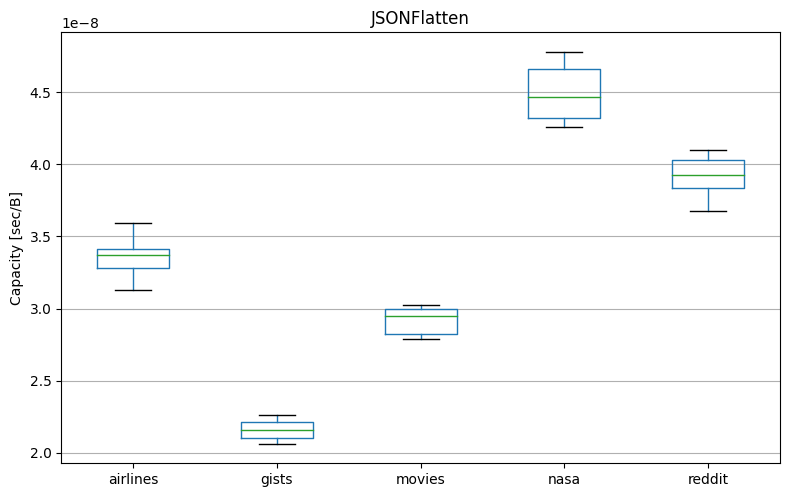

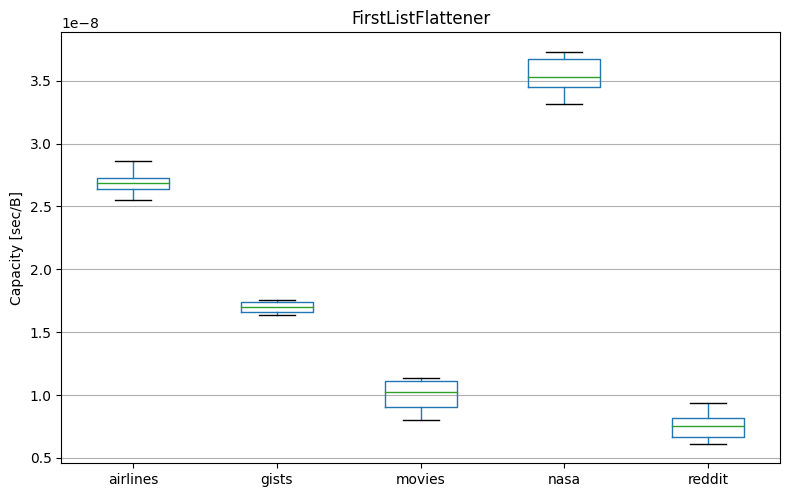

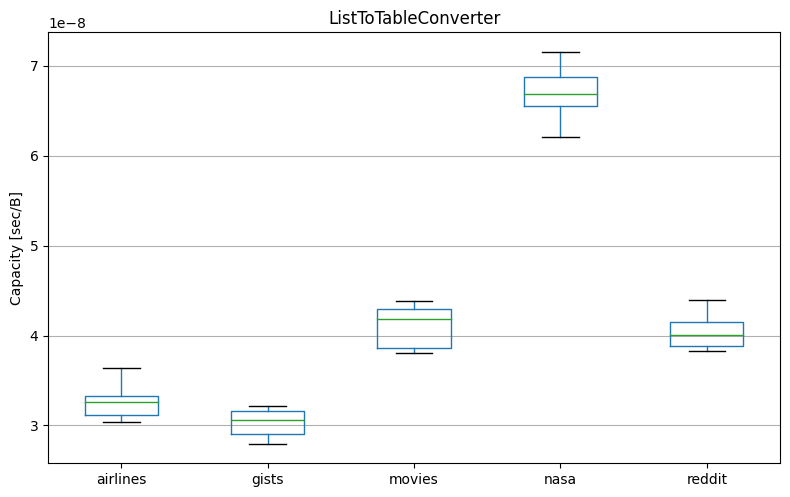

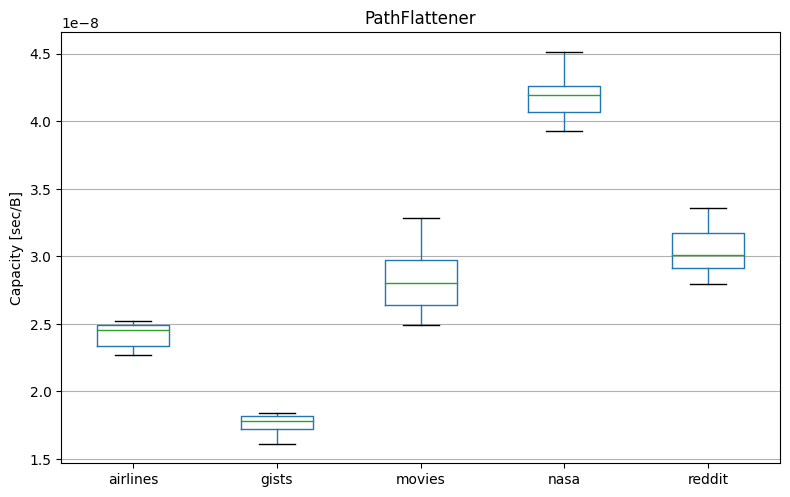

In [43]:
def time_plot_per_method():
    tests = [
        "airlines",
        "gists",
        "movies",
        "nasa",
        "reddit",
    ]

    data = {}
    for test in tests:
        (TEST_FILES, DUMMY_FILE, SOURCE_FILE_SIZE, title, output_file) = get_test_props(test)
        for filename, plot_name in TEST_FILES:
            if plot_name not in data:
                data[plot_name] = {}

            values = clear_values(DUMMY_FILE, filename, SOURCE_FILE_SIZE)
            data[plot_name][test] = values.copy()

    #print(data)

    df_time_duration = pd.DataFrame()
    for method in data.keys():
        for test in data[method].keys():
            df_time_duration[test] = data[method][test]

        axes = df_time_duration.boxplot(figsize=(8, 5), grid=False)
        axes.grid(axis="y")
        axes.set_ylabel('Capacity [sec/B]')
        plt.tight_layout()

        plt.title(method)
        plt.savefig(f"time/charts/{method}.png")
        plt.show()

time_plot_per_method()

# ANALYZE ONLY

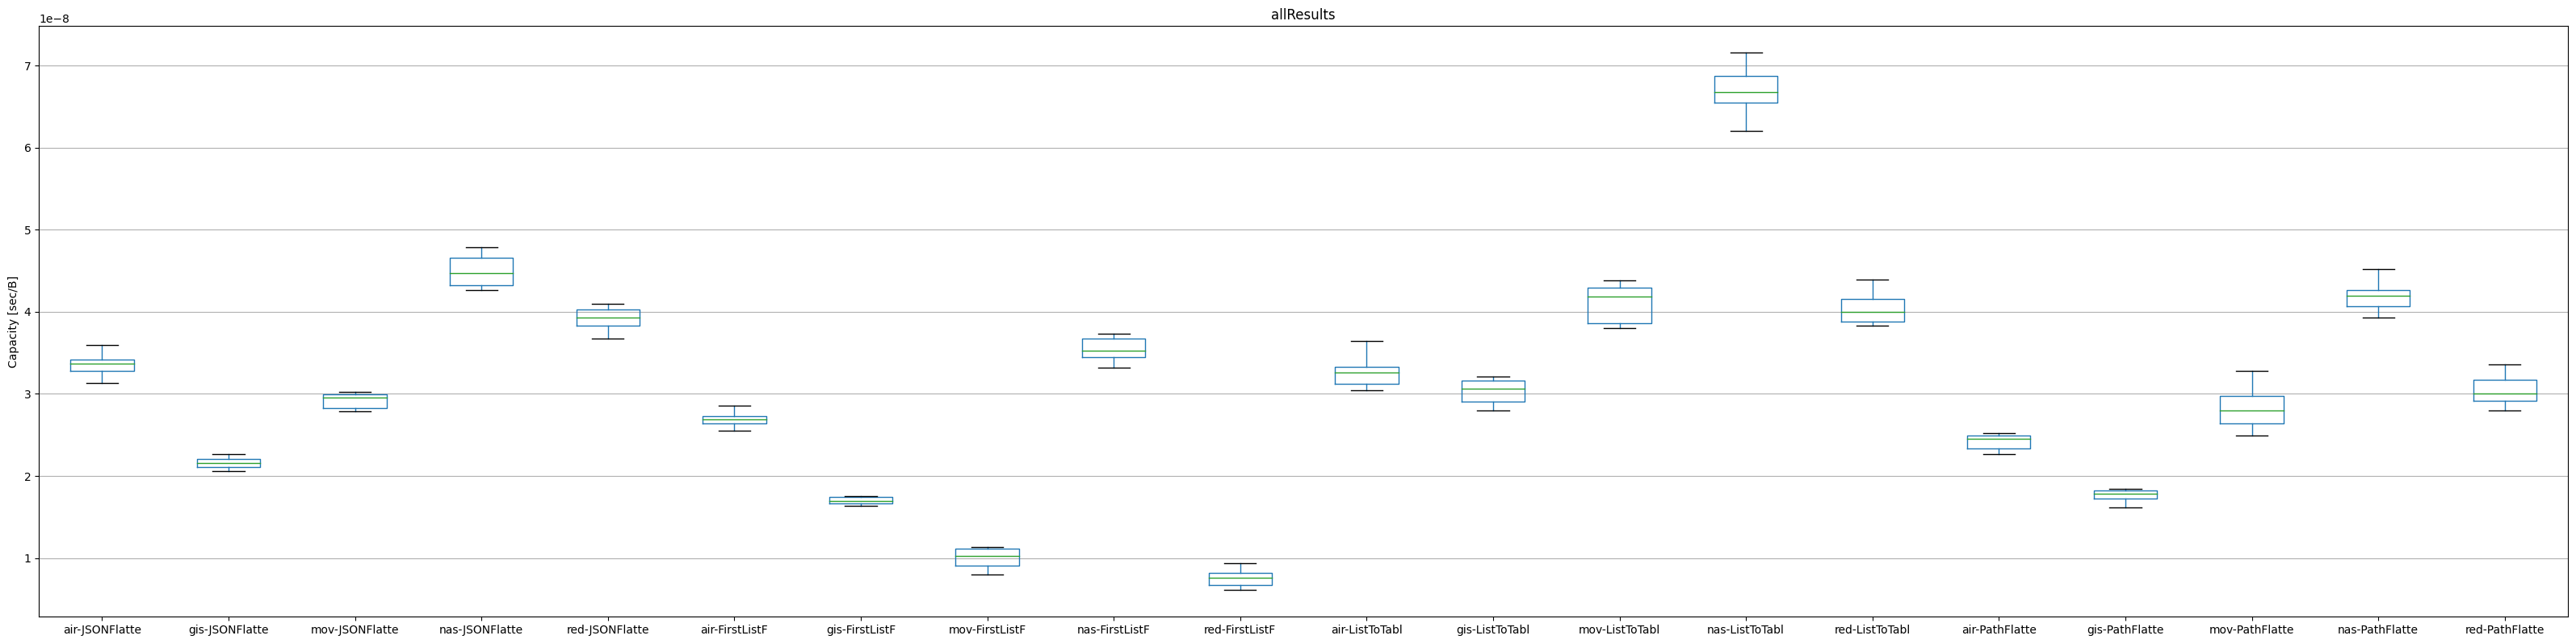

In [44]:
MAX_MEASURES = 12

def get_test_props(test_name: str):
    SOURCE_FILE_SIZE = os.stat(f"../../data/testFiles/{test_name}.txt").st_size
    TEST_FILES = [
        (f"time/{test_name}-JSONFlatten.txt", "JSONFlatten"),
        (f"time/{test_name}-JSONFirstListFlattener.txt", "FirstListFlattener"),
        (f"time/{test_name}-JSONListToTableConverter.txt", "ListToTableConverter"),
        (f"time/{test_name}-JSONPathFlattener.txt", "PathFlattener"),
    ]
    DUMMY_FILE = f"time/{test_name}-JSONDummy.txt"
    output_file = f"time/charts/{test_name}.png"

    return (TEST_FILES, DUMMY_FILE, SOURCE_FILE_SIZE, test_name, output_file)

def clear_values(DUMMY_FILE, filename, SOURCE_FILE_SIZE):
    with open(DUMMY_FILE) as file:
        dummy_values = np.array(file.read().split()).astype(float)

    values = np.array([])
    with open(filename) as file:
        unclean_values = np.array(file.read().split()).astype(float)
        values = unclean_values - dummy_values

        mask = np.ones(len(values), dtype=bool)
        mask[np.argmin(values)] = mask[np.argmax(values)] = False
        values = values[mask]

        # Take only the first 12 measures
        if len(values) > MAX_MEASURES:
            values = values[:MAX_MEASURES]

        # Divide all values by file size
        values = values / SOURCE_FILE_SIZE

    return values

def time_plot_ALL():
    tests = [
        "airlines",
        "gists",
        "movies",
        "nasa",
        "reddit",
    ]

    data = {}
    for test in tests:
        (TEST_FILES, DUMMY_FILE, SOURCE_FILE_SIZE, title, output_file) = get_test_props(test)
        for filename, plot_name in TEST_FILES:
            if plot_name not in data:
                data[plot_name] = {}

            values = clear_values(DUMMY_FILE, filename, SOURCE_FILE_SIZE)
            data[plot_name][test] = values.copy()

    #print(data)

    df_time_duration = pd.DataFrame()
    for method in data.keys():
        for test in data[method].keys():
            df_time_duration[f"{test[0:3]}-{method[0:10]}"] = data[method][test]

    axes = df_time_duration.boxplot(figsize=(32, 8), grid=False)
    axes.grid(axis="y")
    axes.set_ylabel('Capacity [sec/B]')
    plt.tight_layout()

    plt.title("allResults")
    # plt.xticks(rotation=45)
    plt.savefig("time/charts/allResults.png")
    plt.show()

time_plot_ALL()

### Time measures with ballooner

In [45]:
# MAX_MEASURES = 12
# DIRECTORY_PATH = "time/"
# txt_files = glob.glob(os.path.join(DIRECTORY_PATH, "*.txt"))
# files = [os.path.basename(file) for file in txt_files]

# main_time_dict = {}
# """ example structure
# {
#     ('nasa', '100000', '15000'): {
#         'json_dummy': [80.9, 75.025, 77.25, 56.425],
#         'json_first_list_flattener': [81.92, 70.76, 76.575, 58.025, 77.8, 68.9]
#     },
#     ('nasa', '1000000', '12000'): {
#         'json_dummy': [78.46, 90.97, 80.784, 88.621]
#     }
# }
# """

# for filename in files:
#     file_tags = filename.split("-")
#     time_key = (file_tags[0], file_tags[1]) # dataset, dataset_size
#     flatter_key = file_tags[2] # flatter_method

#     if time_key not in main_time_dict:
#         main_time_dict[time_key] = {}

#     with open(DIRECTORY_PATH + filename) as file:
#         data = np.array(file.read().split()).astype(float)
#         if len(data) > MAX_MEASURES:
#             data = data[-MAX_MEASURES:]  # Take only the last 12 measures
#         main_time_dict[time_key][flatter_key] = data

# print("Keys of main_time_dict:")
# for key in main_time_dict.keys():
#     print(key)

# def draw_time_plot(key: tuple):
#     if key not in main_time_dict.keys():
#         print(f"Key {key} not found!")
#         return

#     measurements = main_time_dict[key].copy()
#     DUMMY_KEY = "json_dummy.txt"
#     if DUMMY_KEY not in measurements.keys():
#         print(f"DUMMY_KEY not found!")
#         return

#     dummy_values = measurements[DUMMY_KEY]
#     measurements.pop(DUMMY_KEY)

#     if (dummy_values is None or len(dummy_values) < 1):
#         print("No dummy measures!")
#         return

#     df_time_duration = pd.DataFrame()
#     for method, time in measurements.items():
#         unclean_values = np.array(time).astype(float)
#         while len(dummy_values) < len(unclean_values):
#             dummy_values = np.append(dummy_values, dummy_values[-1])

#         values = unclean_values - dummy_values[:len(unclean_values)]

#         mask = np.ones(len(values), dtype=bool)
#         mask[np.argmin(values)] = mask[np.argmax(values)] = False
#         mask = values > 0
#         values = values[mask]

#         df_time_duration[method] = pd.DataFrame(values)

#     axes = df_time_duration.boxplot(figsize=(8,5), grid=False)
#     # axes.set_yscale('log')
#     axes.grid(axis='y')
#     plt.tight_layout()
#     plt.show()


In [46]:
# draw_time_plot(('airlines', '1000000'))
# draw_time_plot(('movies', '1000000'))
# draw_time_plot(('nasa', '1000000'))

# draw_time_plot(('gists', '100000'))
# draw_time_plot(('reddit', '10000'))